# 病床姿勢監測 - 資料準備與對齊（Version 3 - 修正時間戳）

**專案**: 熱成像超解析度 + 姿勢辨識  
**作者**: rochi190  
**日期**: 2025-11-04  
**版本**: v3 - 修正 Thermal 時間戳解析（手動加上毫秒偏移）

## 修正重點
- ✅ **Thermal 時間戳只有秒級精度**，手動加上毫秒偏移（125ms/幀）
- ✅ 每個 Thermal 幀配對到不同的 RGB 幀（不再重複）
- ✅ RGB 幀間隔約 3 幀（符合 8fps vs 24.67fps 的比例）

## 功能
1. 讀取 output.txt 取得相機開始時間
2. 載入熱成像 log 檔案（多核加速 + **修正時間戳**）
3. 分析 RGB 影片資訊
4. **Adaptive 配對策略**（處理不固定 FPS 和資料遺漏）
5. 翻轉檢測與修復
6. 匯出 RGB 圖片供 LabelMe 標註（多核加速）
7. 儲存對齊後的 Thermal 資料

## 輸出
- `output/labelme_project/` - LabelMe 標註專案
- `output/aligned_dataset/` - 對齊後的訓練資料
- `output/adaptive_pairing/` - 配對分析結果

---
## Step 0: 環境設定與套件匯入

In [1]:
import os
import sys
import json
import re
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime, timedelta
from typing import List, Dict, Tuple, Optional, Any
from tqdm import tqdm
from dataclasses import dataclass, field
from concurrent.futures import ProcessPoolExecutor
from collections import defaultdict, Counter
import multiprocessing as mp
import warnings
warnings.filterwarnings('ignore')

# Matplotlib 設定
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 100

# Seaborn 樣式
sns.set_style('whitegrid')

print("="*70)
print("病床姿勢監測系統 - 資料準備模組 v3（修正時間戳）")
print("="*70)
print(f"執行時間: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"使用者: rochi190")
print(f"Python 版本: {sys.version}")
print(f"NumPy 版本: {np.__version__}")
print(f"OpenCV 版本: {cv2.__version__}")
print(f"CPU 核心數: {mp.cpu_count()}")
print("="*70)

病床姿勢監測系統 - 資料準備模組 v3（修正時間戳）
執行時間: 2025-11-18 22:35:00
使用者: rochi190
Python 版本: 3.11.13 (main, Jun  5 2025, 13:12:00) [GCC 11.2.0]
NumPy 版本: 2.3.4
OpenCV 版本: 4.10.0
CPU 核心數: 4


---
## Step 1: 路徑與參數配置

In [2]:
# ========================================
# 多核處理配置
# ========================================
NUM_WORKERS = max(1, mp.cpu_count() - 1)
CHUNK_SIZE = 100

print(f"🚀 多核處理配置:")
print(f"  使用 Workers: {NUM_WORKERS}")
print(f"  批次大小: {CHUNK_SIZE}")

# ========================================
# 路徑配置
# ========================================
BASE_DIR = Path(os.getcwd())
DATA_DIR = BASE_DIR / 'gary'
THERMAL_DIR = DATA_DIR / 'thermal'
CAMERA_DIR = DATA_DIR / 'camera'
OUTPUT_TXT = CAMERA_DIR / 'output.txt'
AVI_FILE = CAMERA_DIR / 'WIN_20251116_19_23_26_Pro.mp4'

# 輸出目錄
OUTPUT_DIR = BASE_DIR / 'outputgary'
ADAPTIVE_DIR = OUTPUT_DIR / 'adaptive_pairing'
LABELME_DIR = OUTPUT_DIR / 'labelme_project'
ALIGNED_DIR = OUTPUT_DIR / 'aligned_dataset'
DIAGNOSTIC_DIR = OUTPUT_DIR / 'diagnostics'

for directory in [ADAPTIVE_DIR, LABELME_DIR, ALIGNED_DIR, DIAGNOSTIC_DIR]:
    directory.mkdir(parents=True, exist_ok=True)

# ========================================
# 熱成像參數
# ========================================
THERMAL_RESOLUTION = (32, 24)  # (寬度, 高度)
THERMAL_WIDTH, THERMAL_HEIGHT = THERMAL_RESOLUTION

# ========================================
# Adaptive 配對參數
# ========================================
TARGET_FPS = 8  # 目標 FPS
NORMAL_FRAMES_PER_SEC = 8  # 正常每秒幀數
FRAME_INTERVAL_MS = 1000 / TARGET_FPS  # 125ms

# 翻轉設定（執行 Step 8 後調整）
FLIP_THERMAL = True
FLIP_RGB = False

# ========================================
# 顯示配置
# ========================================
print(f"\n📁 路徑檢查:")
print(f"  Thermal 目錄: {'✓' if THERMAL_DIR.exists() else '✗'} {THERMAL_DIR}")
print(f"  Camera 目錄: {'✓' if CAMERA_DIR.exists() else '✗'} {CAMERA_DIR}")
print(f"  output.txt: {'✓' if OUTPUT_TXT.exists() else '✗'} {OUTPUT_TXT}")
print(f"  AVI 檔案: {'✓' if AVI_FILE.exists() else '✗'} {AVI_FILE}")

print(f"\n⚙️ 配對參數:")
print(f"  目標 FPS: {TARGET_FPS}")
print(f"  幀間隔: {FRAME_INTERVAL_MS:.1f}ms")

print(f"\n🔄 翻轉設定:")
print(f"  翻轉 Thermal: {FLIP_THERMAL}")
print(f"  翻轉 RGB: {FLIP_RGB}")

🚀 多核處理配置:
  使用 Workers: 3
  批次大小: 100

📁 路徑檢查:
  Thermal 目錄: ✓ /home/gary/claude4.5/gary/thermal
  Camera 目錄: ✓ /home/gary/claude4.5/gary/camera
  output.txt: ✓ /home/gary/claude4.5/gary/camera/output.txt
  AVI 檔案: ✓ /home/gary/claude4.5/gary/camera/WIN_20251116_19_23_26_Pro.mp4

⚙️ 配對參數:
  目標 FPS: 8
  幀間隔: 125.0ms

🔄 翻轉設定:
  翻轉 Thermal: True
  翻轉 RGB: False


---
## Step 2: 解析 output.txt（相機開始時間）

In [3]:
def parse_output_txt(txt_path: Path) -> Optional[datetime]:
    """
    解析 output.txt 取得相機開始時間
    """
    if not txt_path.exists():
        print(f"❌ {txt_path} 不存在")
        return None
    
    try:
        with open(txt_path, 'r', encoding='utf-8') as f:
            content = f.read()
    except:
        with open(txt_path, 'r', encoding='big5') as f:
            content = f.read()
    
    print(f"\n{'='*70}")
    print(f"解析 output.txt")
    print(f"{'='*70}")
    print(f"檔案大小: {len(content)} bytes")
    print(f"\n前 500 字元:\n{content[:500]}")
    print(f"{'='*70}")
    
    # 時間格式模式
    patterns = [
        (r'(\d{4}-\d{2}-\d{2}\s+\d{2}:\d{2}:\d{2})', '%Y-%m-%d %H:%M:%S'),
        (r'(\d{4}/\d{2}/\d{2}\s+\d{2}:\d{2}:\d{2})', '%Y/%m/%d %H:%M:%S'),
    ]
    
    for pattern, fmt in patterns:
        match = re.search(pattern, content)
        if match:
            try:
                camera_start = datetime.strptime(match.group(1), fmt)
                print(f"\n✅ 找到相機開始時間: {camera_start}")
                return camera_start
            except:
                continue
    
    print(f"\n❌ 無法解析時間")
    return None

# 執行解析
#camera_start_time = parse_output_txt(OUTPUT_TXT)
camera_start_time = datetime(2025, 11, 16, 19, 23, 26)  
if camera_start_time is None:
    raise RuntimeError("❌ 無法解析 output.txt，請檢查檔案格式")

print(f"\n📌 相機開始時間: {camera_start_time}")


📌 相機開始時間: 2025-11-16 19:23:26


---
## Step 3: 載入熱成像資料（修正版：手動加上毫秒偏移）

In [4]:
def parse_thermal_file(file_path: Path) -> List[Dict]:
    """
    解析單一熱成像 log 檔案（修正版）
    
    修正：
    - time 格式: [年, 月, 日, 時, 分, 秒, 星期, 年中天數, 夏令時]
    - 沒有毫秒資訊，手動根據順序加上偏移
    - 假設 8fps，每幀間隔 125ms
    """
    data = []
    
    # 用於追蹤每一秒內的幀數
    second_frame_counts = {}
    
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                
                try:
                    data_dict = json.loads(line)
                    time_parts = data_dict.get('time', [])
                    
                    if len(time_parts) < 6:
                        continue
                    
                    year, month, day, hour, minute, second = time_parts[:6]
                    
                    # 建立秒級別的 key
                    second_key = (year, month, day, hour, minute, second)
                    
                    # 計算這一秒內的第幾幀
                    if second_key not in second_frame_counts:
                        second_frame_counts[second_key] = 0
                    else:
                        second_frame_counts[second_key] += 1
                    
                    frame_in_second = second_frame_counts[second_key]
                    
                    # 🔧 手動計算毫秒偏移
                    millisecond = int(frame_in_second * FRAME_INTERVAL_MS)
                    
                    # 建立時間戳
                    timestamp = datetime(year, month, day, hour, minute, second, 
                                        min(millisecond * 1000, 999999))
                    
                    message = data_dict.get('message', [])
                    if len(message) != THERMAL_WIDTH * THERMAL_HEIGHT:
                        continue
                    
                    thermal_image = np.array(message, dtype=np.uint8).reshape(
                        THERMAL_HEIGHT, THERMAL_WIDTH
                    )
                    
                    data.append({
                        'timestamp': timestamp,
                        'image': thermal_image
                    })
                    
                except:
                    continue
    
    except Exception as e:
        print(f"❌ 載入失敗 {file_path.name}: {e}")
        return []
    
    return data

# 載入所有 thermal log
log_files = sorted(THERMAL_DIR.glob('log*.txt'))

if not log_files:
    raise FileNotFoundError(f"❌ 未找到 log 檔案於 {THERMAL_DIR}")

print(f"\n{'='*70}")
print(f"載入熱成像資料（多核: {NUM_WORKERS} workers）")
print(f"{'='*70}")
print(f"找到 {len(log_files)} 個 log 檔案")
print(f"🔧 修正：手動加上毫秒偏移（{FRAME_INTERVAL_MS:.1f}ms/幀）")

therm_data = []
with ProcessPoolExecutor(max_workers=NUM_WORKERS) as executor:
    results = list(tqdm(
        executor.map(parse_thermal_file, log_files),
        total=len(log_files),
        desc="載入 Thermal"
    ))

for file_data in results:
    therm_data.extend(file_data)

# 排序
therm_data.sort(key=lambda x: x['timestamp'])

print(f"\n✅ 載入完成")
print(f"  總幀數: {len(therm_data):,}")
if therm_data:
    thermal_start = therm_data[0]['timestamp']
    thermal_end = therm_data[-1]['timestamp']
    duration = (thermal_end - thermal_start).total_seconds()
    print(f"  時間範圍: {thermal_start} ~ {thermal_end}")
    print(f"  時長: {duration:.2f} 秒")
    print(f"  平均 FPS: {len(therm_data) / duration:.2f}")
    
    # 檢查時間間隔
    time_diffs = []
    for i in range(min(100, len(therm_data) - 1)):
        dt = (therm_data[i+1]['timestamp'] - therm_data[i]['timestamp']).total_seconds() * 1000
        time_diffs.append(dt)
    
    print(f"\n  時間間隔統計（前 100 幀）:")
    print(f"    平均: {np.mean(time_diffs):.1f}ms")
    print(f"    中位數: {np.median(time_diffs):.1f}ms")
    print(f"    預期: {FRAME_INTERVAL_MS:.1f}ms")

print("="*70)


載入熱成像資料（多核: 3 workers）
找到 3 個 log 檔案
🔧 修正：手動加上毫秒偏移（125.0ms/幀）


載入 Thermal: 100%|██████████| 3/3 [00:00<00:00, 24.92it/s]


✅ 載入完成
  總幀數: 3,102
  時間範圍: 2025-11-16 19:23:24 ~ 2025-11-16 19:30:02
  時長: 398.00 秒
  平均 FPS: 7.79

  時間間隔統計（前 100 幀）:
    平均: 135.0ms
    中位數: 125.0ms
    預期: 125.0ms


---
## Step 4: 分析 RGB 影片

In [5]:
# 分析 AVI 影片
cap = cv2.VideoCapture(str(AVI_FILE))

if not cap.isOpened():
    raise RuntimeError(f"❌ 無法開啟影片 {AVI_FILE}")

fps = cap.get(cv2.CAP_PROP_FPS)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
duration = frame_count / fps if fps > 0 else 0

cap.release()

print(f"\n{'='*70}")
print(f"RGB 影片資訊")
print(f"{'='*70}")
print(f"  FPS: {fps:.2f}")
print(f"  總幀數: {frame_count:,}")
print(f"  解析度: {width} × {height}")
print(f"  時長: {duration:.2f} 秒")
print(f"  開始時間: {camera_start_time}")
print(f"  結束時間: {camera_start_time + timedelta(seconds=duration)}")
print(f"\n  預期 Thermal-RGB 幀間隔:")
print(f"    Thermal 間隔: {FRAME_INTERVAL_MS:.1f}ms")
print(f"    RGB 間隔: {1000/fps:.1f}ms")
print(f"    每個 Thermal 對應 RGB 幀數: {FRAME_INTERVAL_MS / (1000/fps):.1f}")
print("="*70)


RGB 影片資訊
  FPS: 30.00
  總幀數: 11,751
  解析度: 960 × 720
  時長: 391.73 秒
  開始時間: 2025-11-16 19:23:26
  結束時間: 2025-11-16 19:29:57.729233

  預期 Thermal-RGB 幀間隔:
    Thermal 間隔: 125.0ms
    RGB 間隔: 33.3ms
    每個 Thermal 對應 RGB 幀數: 3.7


step 4.5

In [6]:
def analyze_thermal_distribution(thermal_data: List[Dict], camera_start_time: datetime) -> Dict:
    """
    分析熱成像資料的時間分佈
    將幀按秒分組
    """
    sections = {}
    
    for frame in thermal_data:
        offset = (frame['timestamp'] - camera_start_time).total_seconds()
        
        if offset < 0:
            continue
        
        second = int(offset)
        if second not in sections:
            sections[second] = []
        sections[second].append(frame)
    
    print(f"\n{'='*70}")
    print(f"熱成像時間分佈分析")
    print(f"{'='*70}")
    
    section_counts = {sec: len(frames) for sec, frames in sections.items()}
    counts = list(section_counts.values())
    
    print(f"\n總秒數: {len(sections)}")
    print(f"最小幀數/秒: {min(counts)}")
    print(f"最大幀數/秒: {max(counts)}")
    print(f"平均幀數/秒: {np.mean(counts):.1f}")
    print(f"標準差: {np.std(counts):.1f}")
    
    # 分類
    normal_seconds = [sec for sec, count in section_counts.items() if count == NORMAL_FRAMES_PER_SEC]
    dropout_seconds = [sec for sec, count in section_counts.items() if count < NORMAL_FRAMES_PER_SEC]
    burst_seconds = {sec: count for sec, count in section_counts.items() if count > NORMAL_FRAMES_PER_SEC}
    
    print(f"\n正常 ({NORMAL_FRAMES_PER_SEC} 張/秒): {len(normal_seconds)} 秒")
    print(f"Dropout (<{NORMAL_FRAMES_PER_SEC} 張/秒): {len(dropout_seconds)} 秒")
    print(f"Burst (>{NORMAL_FRAMES_PER_SEC} 張/秒): {len(burst_seconds)} 秒")
    
    if burst_seconds:
        print(f"\nBurst 範例（前 5 秒）:")
        for sec, count in sorted(burst_seconds.items(), key=lambda x: x[1], reverse=True)[:5]:
            print(f"  第 {sec} 秒: {count} 張 (多 {count - NORMAL_FRAMES_PER_SEC} 張)")
    
    print("="*70)
    
    return sections

# 執行分析
sections = analyze_thermal_distribution(therm_data, camera_start_time)


熱成像時間分佈分析

總秒數: 397
最小幀數/秒: 1
最大幀數/秒: 9
平均幀數/秒: 7.8
標準差: 0.6

正常 (8 張/秒): 283 秒
Dropout (<8 張/秒): 96 秒
Burst (>8 張/秒): 18 秒

Burst 範例（前 5 秒）:
  第 7 秒: 9 張 (多 1 張)
  第 31 秒: 9 張 (多 1 張)
  第 73 秒: 9 張 (多 1 張)
  第 75 秒: 9 張 (多 1 張)
  第 84 秒: 9 張 (多 1 張)


---
## Step 5: 簡化配對（直接按時間戳配對）

In [7]:
def proper_thermal_rgb_pairing_final(
    thermal_data: List[Dict],
    camera_start_time: datetime,
    fps: float,
    frame_count: int,
    sections: Dict
) -> Tuple[List[Dict], List[Dict]]:
    """
    最終配對邏輯：
    1. 按秒分組 IR
    2. 修復嚴重 burst（≥16 張）
    3. 每秒有幾張 IR，就在該秒的 RGB 均勻切出相同數量的幀
    """
    
    print(f"\n{'='*70}")
    print(f"Thermal-RGB 配對（按秒均勻切 RGB）")
    print(f"{'='*70}")
    
    NORMAL_FRAMES = 8
    SERIOUS_BURST_THRESHOLD = 16
    
    # Step 1: 檢查時間範圍
    print(f"\n1️⃣ 檢查時間範圍:")
    
    rgb_duration = frame_count / fps
    rgb_end_time = camera_start_time + timedelta(seconds=rgb_duration)
    ir_end_time = thermal_data[-1]['timestamp']
    time_diff = abs((ir_end_time - rgb_end_time).total_seconds())
    
    print(f"   相機開始: {camera_start_time}")
    print(f"   IR 結束: {ir_end_time}")
    print(f"   RGB 結束: {rgb_end_time}")
    print(f"   時間差: {time_diff:.2f} 秒")
    print(f"   RGB FPS: {fps:.2f} (可能不固定)")
    
    if time_diff > 2:
        print(f"   ⚠️ 時間差異超過 2 秒，可能有人為誤差")
    
    # Step 2: 補充缺失的秒
    min_sec = min(sections.keys())
    max_sec = max(sections.keys())
    
    for sec in range(min_sec, max_sec + 1):
        if sec not in sections:
            sections[sec] = []
    
    # Step 3: 分類並修復嚴重 burst
    print(f"\n2️⃣ 分類與修復:")
    
    serious_bursts = {}
    mild_cases = {}
    missing = []
    
    for sec, frames in sections.items():
        count = len(frames)
        
        if count >= SERIOUS_BURST_THRESHOLD:
            serious_bursts[sec] = count
        elif count in [7, 9]:
            mild_cases[sec] = count
        elif count == 0:
            missing.append(sec)
    
    print(f"   嚴重 Burst (≥{SERIOUS_BURST_THRESHOLD} 張): {len(serious_bursts)} 秒")
    print(f"   輕微情況 (7 或 9 張): {len(mild_cases)} 秒")
    print(f"   完全缺失: {len(missing)} 秒")
    
    # 修復嚴重 burst
    if serious_bursts:
        print(f"\n   修復嚴重 Burst:")
        total_redistributed = 0
        
        for burst_sec in sorted(serious_bursts.keys()):
            frames = sections[burst_sec]
            excess_count = len(frames) - NORMAL_FRAMES
            
            # 只補完全缺失的秒
            available_targets = [sec for sec in missing if sec < burst_sec]
            
            if not available_targets:
                sections[burst_sec] = frames[-NORMAL_FRAMES:]
                print(f"      第 {burst_sec} 秒: 丟棄 {excess_count} 幀")
                continue
            
            excess_frames = frames[:excess_count]
            sections[burst_sec] = frames[excess_count:]
            
            frame_idx = 0
            for target_sec in sorted(available_targets):
                if frame_idx >= len(excess_frames):
                    break
                
                if len(sections[target_sec]) > 0:
                    continue
                
                frame = excess_frames[frame_idx]
                frame['timestamp'] = camera_start_time + timedelta(seconds=target_sec)
                sections[target_sec].append(frame)
                
                frame_idx += 1
                total_redistributed += 1
            
            print(f"      第 {burst_sec} 秒: 補充 {frame_idx} 幀到前面缺失的秒")
        
        print(f"   ✓ 成功補充: {total_redistributed} 幀")
    
    # Step 4: 按秒配對（核心邏輯）
    print(f"\n3️⃣ 按秒配對 Thermal-RGB:")
    
    pairs = []
    stats = {
        'normal': 0,      # 8 張
        'minor': 0,       # 7 或 9 張
        'missing': 0,     # 0 張
        'other': 0        # 其他
    }
    
    for sec in sorted(sections.keys()):
        ir_frames = sections[sec]
        ir_count = len(ir_frames)
        
        if ir_count == 0:
            stats['missing'] += 1
            continue
        
        # 計算該秒在 RGB 影片中的幀範圍
        # 關鍵：用 fps 估算，但均勻分配避免累積誤差
        sec_start_frame = int(sec * fps)
        sec_end_frame = int((sec + 1) * fps)
        
        # 確保不超出影片範圍
        sec_start_frame = max(0, min(sec_start_frame, frame_count - 1))
        sec_end_frame = max(0, min(sec_end_frame, frame_count))
        
        # 關鍵：均勻分配 RGB 幀
        if ir_count == 1:
            # 只有 1 張 IR，取該秒中間的 RGB 幀
            rgb_indices = [(sec_start_frame + sec_end_frame) // 2]
        else:
            # 多張 IR，均勻分配
            # 使用 linspace 確保均勻分佈
            rgb_indices = np.linspace(
                sec_start_frame,
                sec_end_frame - 1,
                ir_count,
                dtype=int
            )
        
        # 配對
        for ir_frame, rgb_idx in zip(ir_frames, rgb_indices):
            rgb_idx = int(np.clip(rgb_idx, 0, frame_count - 1))
            
            offset = (ir_frame['timestamp'] - camera_start_time).total_seconds()
            actual_time = rgb_idx / fps
            rgb_error = abs(actual_time - offset)
            
            pairs.append({
                'pair_id': f'pair_{len(pairs):05d}',
                'thermal': ir_frame,
                'rgb_frame_idx': rgb_idx,
                'timestamp': ir_frame['timestamp'],
                'section': sec,
                'rgb_error_ms': rgb_error * 1000
            })
        
        # 統計
        if ir_count == 8:
            stats['normal'] += 1
        elif ir_count in [7, 9]:
            stats['minor'] += 1
        else:
            stats['other'] += 1
        
        # 每 10 秒打印一次進度
        if sec % 10 == 0:
            print(f"   第 {sec} 秒: {ir_count} 張 IR → RGB 幀 {rgb_indices[0]} ~ {rgb_indices[-1]}")
    
    # Step 5: 統計結果
    print(f"\n4️⃣ 配對結果:")
    print(f"   總配對數: {len(pairs):,}")
    print(f"   成功率: {len(pairs) / len(thermal_data) * 100:.1f}%")
    print(f"\n   秒數分佈:")
    print(f"     正常 (8 張): {stats['normal']} 秒")
    print(f"     輕微 (7/9 張): {stats['minor']} 秒")
    print(f"     缺失 (0 張): {stats['missing']} 秒")
    print(f"     其他: {stats['other']} 秒")
    
    if pairs:
        rgb_errors = [p['rgb_error_ms'] for p in pairs]
        rgb_indices = [p['rgb_frame_idx'] for p in pairs]
        intervals = [rgb_indices[i+1] - rgb_indices[i] for i in range(len(rgb_indices) - 1)]
        
        print(f"\n   配對精度:")
        print(f"     RGB 誤差: 平均 {np.mean(rgb_errors):.2f}ms")
        print(f"     RGB 誤差: 中位數 {np.median(rgb_errors):.2f}ms")
        print(f"     RGB 誤差: 最大 {max(rgb_errors):.2f}ms")
        
        interval_counts = Counter(intervals)
        print(f"\n   RGB 幀間隔分佈:")
        for interval in sorted(interval_counts.keys())[:10]:
            count = interval_counts[interval]
            percentage = count / len(intervals) * 100 if intervals else 0
            print(f"     間隔 {interval:3d} 幀: {count:5d} 次 ({percentage:5.1f}%)")
    
    print("="*70)
    
    return pairs, []

# 執行配對
pairs_adaptive, redistribution_log = proper_thermal_rgb_pairing_final(
    therm_data, camera_start_time, fps, frame_count, sections
)

print(f"\n📌 最終配對結果: {len(pairs_adaptive):,} 對")


Thermal-RGB 配對（按秒均勻切 RGB）

1️⃣ 檢查時間範圍:
   相機開始: 2025-11-16 19:23:26
   IR 結束: 2025-11-16 19:30:02
   RGB 結束: 2025-11-16 19:29:57.729233
   時間差: 4.27 秒
   RGB FPS: 30.00 (可能不固定)
   ⚠️ 時間差異超過 2 秒，可能有人為誤差

2️⃣ 分類與修復:
   嚴重 Burst (≥16 張): 0 秒
   輕微情況 (7 或 9 張): 113 秒
   完全缺失: 0 秒

3️⃣ 按秒配對 Thermal-RGB:
   第 0 秒: 8 張 IR → RGB 幀 0 ~ 28
   第 10 秒: 8 張 IR → RGB 幀 299 ~ 328
   第 20 秒: 8 張 IR → RGB 幀 599 ~ 628
   第 30 秒: 7 張 IR → RGB 幀 899 ~ 928
   第 40 秒: 7 張 IR → RGB 幀 1199 ~ 1228
   第 50 秒: 7 張 IR → RGB 幀 1499 ~ 1528
   第 60 秒: 7 張 IR → RGB 幀 1799 ~ 1828
   第 70 秒: 7 張 IR → RGB 幀 2099 ~ 2128
   第 80 秒: 8 張 IR → RGB 幀 2399 ~ 2428
   第 90 秒: 8 張 IR → RGB 幀 2699 ~ 2728
   第 100 秒: 8 張 IR → RGB 幀 2999 ~ 3028
   第 110 秒: 9 張 IR → RGB 幀 3299 ~ 3328
   第 120 秒: 8 張 IR → RGB 幀 3599 ~ 3628
   第 130 秒: 8 張 IR → RGB 幀 3899 ~ 3928
   第 140 秒: 8 張 IR → RGB 幀 4199 ~ 4228
   第 150 秒: 8 張 IR → RGB 幀 4499 ~ 4528
   第 160 秒: 8 張 IR → RGB 幀 4799 ~ 4828
   第 170 秒: 8 張 IR → RGB 幀 5099 ~ 5128
   第 180 秒: 8 張 IR 

---
## Step 6: 驗證配對結果

In [8]:
# 檢查配對結果
print(f"\n{'='*70}")
print(f"配對結果驗證")
print(f"{'='*70}")

print(f"\n前 20 個配對:")
for i, pair in enumerate(pairs_adaptive[:20]):
    thermal_time = pair['timestamp'].strftime('%H:%M:%S.%f')[:-3]
    rgb_idx = pair['rgb_frame_idx']
    error = pair['rgb_error_ms']
    
    # 計算與前一幀的間隔
    if i > 0:
        time_diff = (pair['timestamp'] - pairs_adaptive[i-1]['timestamp']).total_seconds() * 1000
        rgb_diff = rgb_idx - pairs_adaptive[i-1]['rgb_frame_idx']
        print(f"{i:2d}. {pair['pair_id']}: Thermal {thermal_time} → RGB 幀 {rgb_idx:5d} (誤差 {error:4.1f}ms, 時間間隔 {time_diff:6.1f}ms, RGB間隔 {rgb_diff} 幀)")
    else:
        print(f"{i:2d}. {pair['pair_id']}: Thermal {thermal_time} → RGB 幀 {rgb_idx:5d} (誤差 {error:4.1f}ms)")

print("="*70)


配對結果驗證

前 20 個配對:
 0. pair_00000: Thermal 19:23:26.000 → RGB 幀     0 (誤差  0.0ms)
 1. pair_00001: Thermal 19:23:26.125 → RGB 幀     4 (誤差  8.3ms, 時間間隔  125.0ms, RGB間隔 4 幀)
 2. pair_00002: Thermal 19:23:26.250 → RGB 幀     8 (誤差 16.7ms, 時間間隔  125.0ms, RGB間隔 4 幀)
 3. pair_00003: Thermal 19:23:26.375 → RGB 幀    12 (誤差 25.0ms, 時間間隔  125.0ms, RGB間隔 4 幀)
 4. pair_00004: Thermal 19:23:26.500 → RGB 幀    16 (誤差 33.4ms, 時間間隔  125.0ms, RGB間隔 4 幀)
 5. pair_00005: Thermal 19:23:26.625 → RGB 幀    20 (誤差 41.7ms, 時間間隔  125.0ms, RGB間隔 4 幀)
 6. pair_00006: Thermal 19:23:26.750 → RGB 幀    24 (誤差 50.1ms, 時間間隔  125.0ms, RGB間隔 4 幀)
 7. pair_00007: Thermal 19:23:26.875 → RGB 幀    28 (誤差 58.4ms, 時間間隔  125.0ms, RGB間隔 4 幀)
 8. pair_00008: Thermal 19:23:27.000 → RGB 幀    29 (誤差 33.3ms, 時間間隔  125.0ms, RGB間隔 1 幀)
 9. pair_00009: Thermal 19:23:27.125 → RGB 幀    33 (誤差 24.9ms, 時間間隔  125.0ms, RGB間隔 4 幀)
10. pair_00010: Thermal 19:23:27.250 → RGB 幀    37 (誤差 16.6ms, 時間間隔  125.0ms, RGB間隔 4 幀)
11. pair_00011: Thermal 19:2

---
## Step 7: 視覺化分析

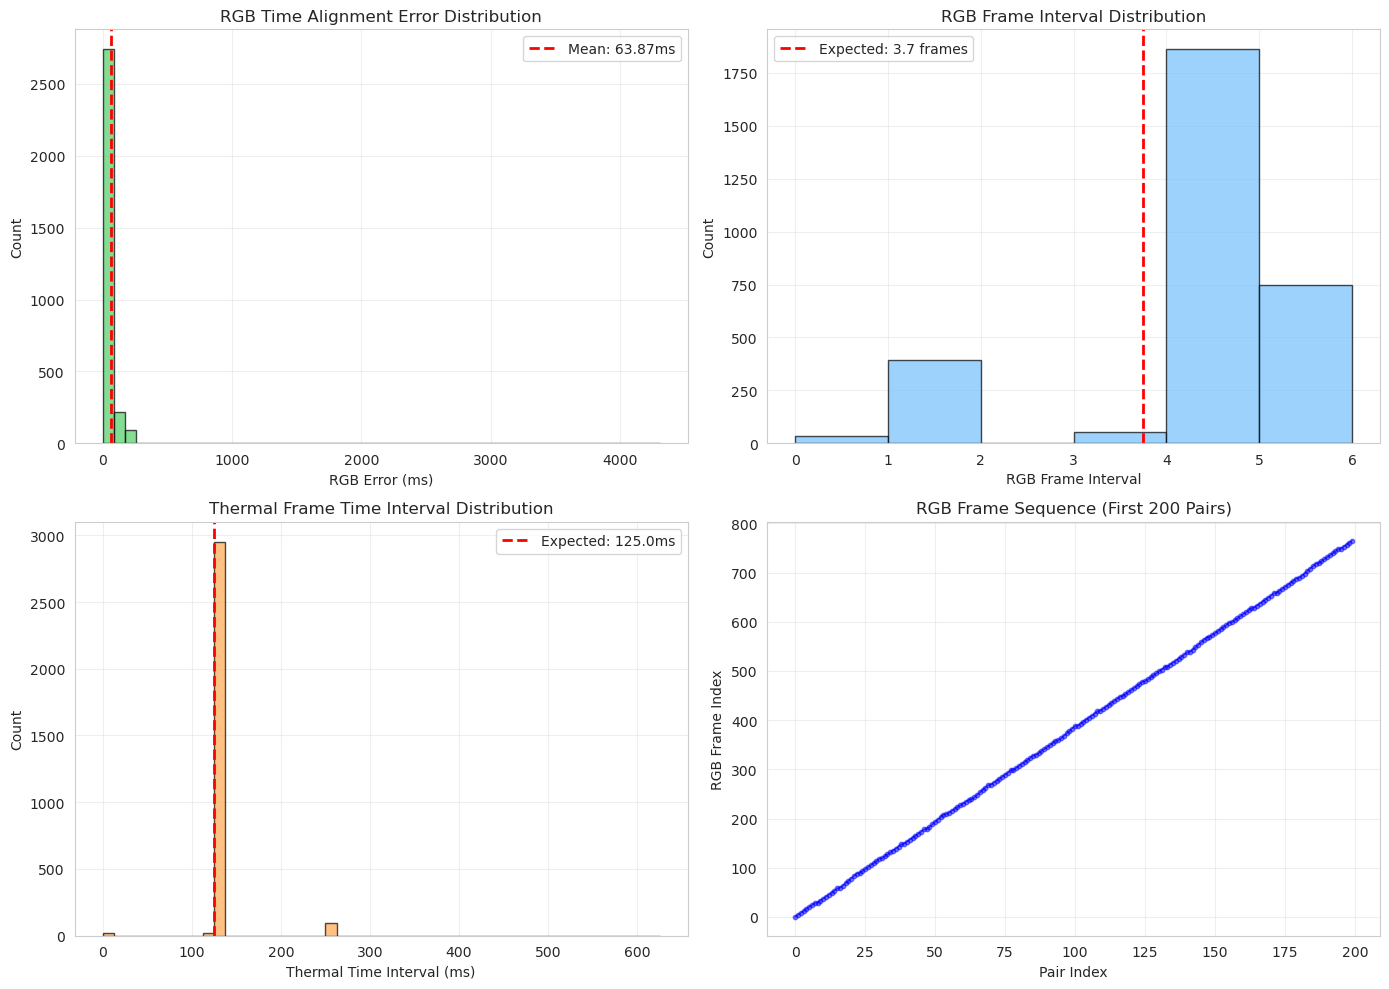


✅ 視覺化已儲存: /home/gary/claude4.5/outputgary/adaptive_pairing/pairing_analysis_v3.png


In [9]:
# 視覺化配對結果
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. RGB 誤差分布
rgb_errors = [p['rgb_error_ms'] for p in pairs_adaptive]
axes[0, 0].hist(rgb_errors, bins=50, edgecolor='black', alpha=0.7, color='#51cf66')
axes[0, 0].axvline(np.mean(rgb_errors), color='red', linestyle='--', linewidth=2, 
                   label=f'Mean: {np.mean(rgb_errors):.2f}ms')
axes[0, 0].set_xlabel('RGB Error (ms)')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('RGB Time Alignment Error Distribution')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. RGB 幀間隔分佈
rgb_indices = [p['rgb_frame_idx'] for p in pairs_adaptive]
intervals = [rgb_indices[i+1] - rgb_indices[i] for i in range(len(rgb_indices) - 1)]

axes[0, 1].hist(intervals, bins=range(0, max(intervals)+2), edgecolor='black', alpha=0.7, color='#74c0fc')
expected_interval = FRAME_INTERVAL_MS / (1000 / fps)
axes[0, 1].axvline(expected_interval, color='red', linestyle='--', linewidth=2,
                   label=f'Expected: {expected_interval:.1f} frames')
axes[0, 1].set_xlabel('RGB Frame Interval')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('RGB Frame Interval Distribution')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Thermal 時間間隔
time_diffs = []
for i in range(len(pairs_adaptive) - 1):
    dt = (pairs_adaptive[i+1]['timestamp'] - pairs_adaptive[i]['timestamp']).total_seconds() * 1000
    time_diffs.append(dt)

axes[1, 0].hist(time_diffs, bins=50, edgecolor='black', alpha=0.7, color='#ffa94d')
axes[1, 0].axvline(FRAME_INTERVAL_MS, color='red', linestyle='--', linewidth=2,
                   label=f'Expected: {FRAME_INTERVAL_MS:.1f}ms')
axes[1, 0].set_xlabel('Thermal Time Interval (ms)')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Thermal Frame Time Interval Distribution')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. RGB 幀序列（前 200 對）
sample_size = min(200, len(rgb_indices))
axes[1, 1].plot(range(sample_size), rgb_indices[:sample_size], 'b-', linewidth=1, alpha=0.7)
axes[1, 1].scatter(range(sample_size), rgb_indices[:sample_size], c='blue', s=10, alpha=0.5)
axes[1, 1].set_xlabel('Pair Index')
axes[1, 1].set_ylabel('RGB Frame Index')
axes[1, 1].set_title(f'RGB Frame Sequence (First {sample_size} Pairs)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
save_path = ADAPTIVE_DIR / 'pairing_analysis_v3.png'
plt.savefig(save_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ 視覺化已儲存: {save_path}")

---
## Step 8: 翻轉檢測


翻轉方向檢測

✅ 翻轉比對圖已儲存: /home/gary/claude4.5/outputgary/diagnostics/flip_comparison.png


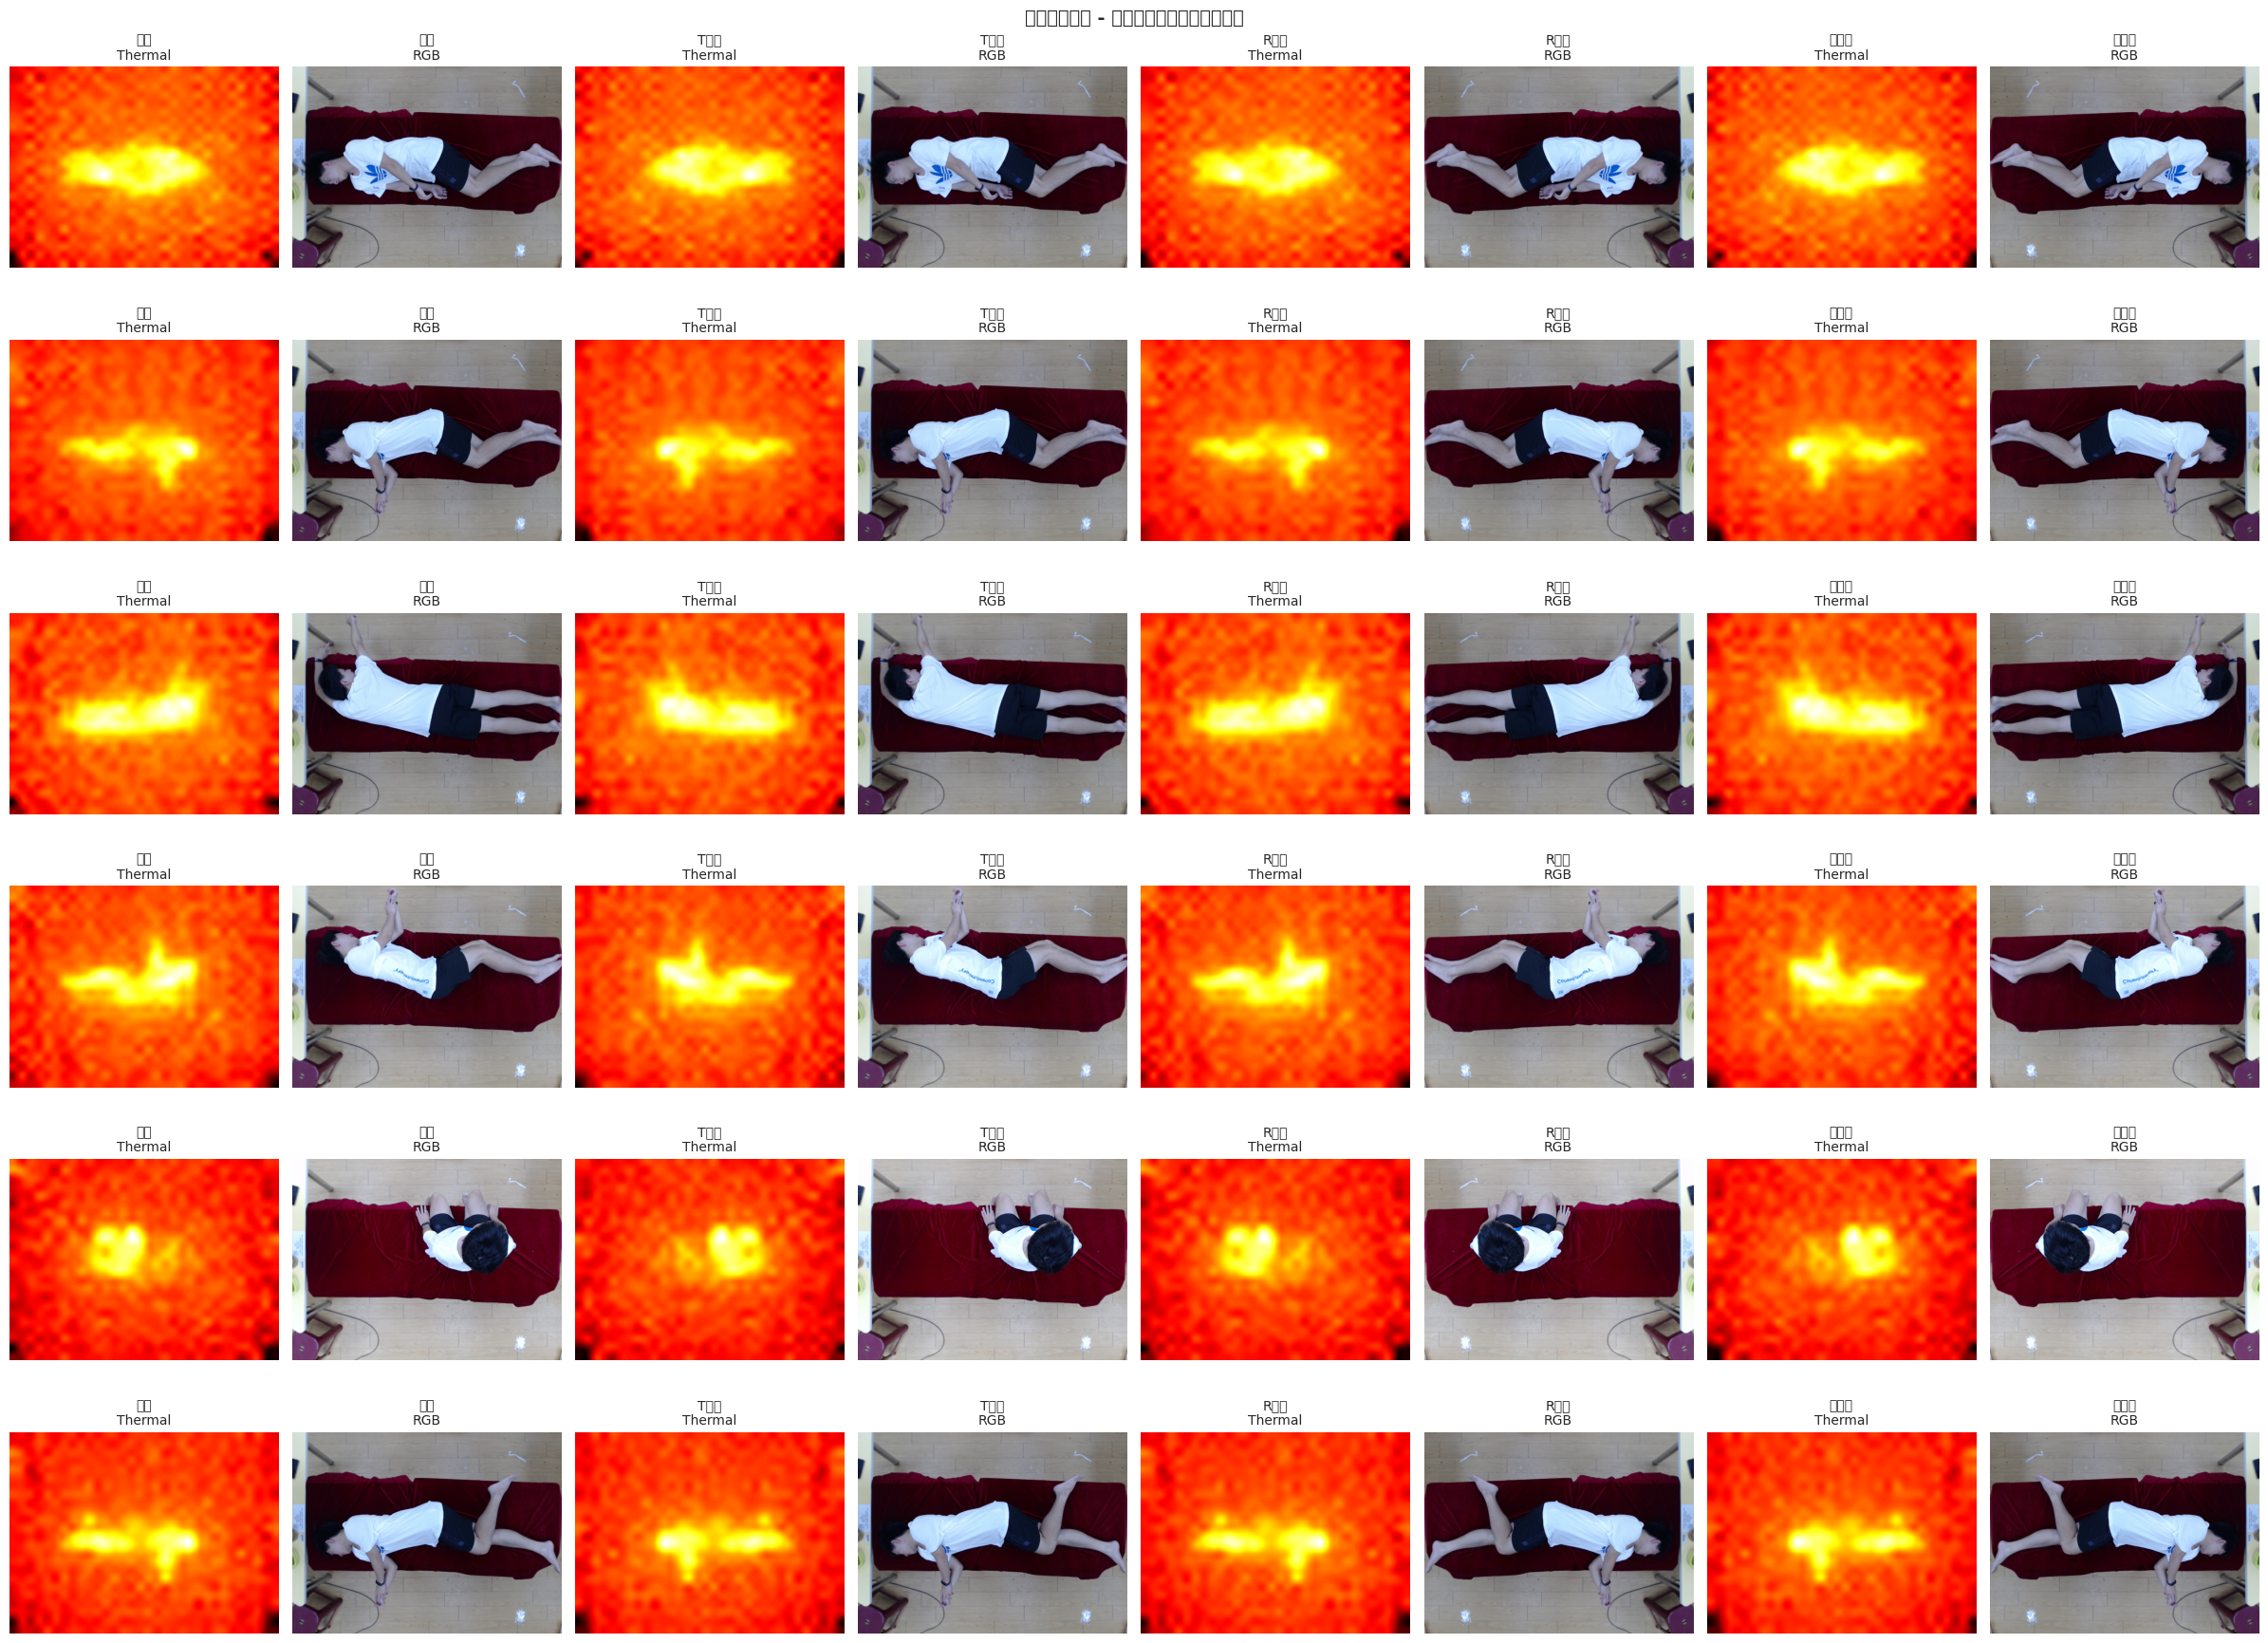


📝 請檢查圖片，判斷哪種組合正確:
  選項 1 - 原始: FLIP_THERMAL=False, FLIP_RGB=False
  選項 2 - T翻轉: FLIP_THERMAL=True, FLIP_RGB=False
  選項 3 - R翻轉: FLIP_THERMAL=False, FLIP_RGB=True
  選項 4 - 都翻轉: FLIP_THERMAL=True, FLIP_RGB=True

確認後請修改 Step 1 的 FLIP_THERMAL 和 FLIP_RGB 參數


In [10]:
def check_flip_orientation(pairs: List[Dict], avi_path: Path, num_samples: int = 6) -> None:
    """
    檢查是否需要左右翻轉
    """
    import random
    
    if not pairs:
        print("❌ 無配對資料可檢查")
        return
    
    print(f"\n{'='*70}")
    print(f"翻轉方向檢測")
    print(f"{'='*70}")
    
    # 隨機取樣
    sample_size = min(num_samples, len(pairs))
    sample_indices = random.sample(range(len(pairs)), sample_size)
    sample_pairs = [pairs[i] for i in sample_indices]
    
    cap = cv2.VideoCapture(str(avi_path))
    
    # 4 種組合
    fig, axes = plt.subplots(num_samples, 8, figsize=(24, num_samples*3))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for row_idx, sample_pair in enumerate(sample_pairs):
        thermal = sample_pair['thermal']['image']
        
        # 讀取 RGB
        cap.set(cv2.CAP_PROP_POS_FRAMES, sample_pair['rgb_frame_idx'])
        ret, rgb = cap.read()
        
        if not ret:
            continue
        
        rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
        
        # 4 種組合
        combinations = [
            (thermal, rgb, "原始", "Both Original"),
            (cv2.flip(thermal, 1), rgb, "T翻轉", "Thermal Flipped"),
            (thermal, cv2.flip(rgb, 1), "R翻轉", "RGB Flipped"),
            (cv2.flip(thermal, 1), cv2.flip(rgb, 1), "都翻轉", "Both Flipped")
        ]
        
        for col_idx, (t, r, label, desc) in enumerate(combinations):
            t_up = cv2.resize(t, (r.shape[1], r.shape[0]), interpolation=cv2.INTER_CUBIC)
            
            # Thermal
            axes[row_idx, col_idx*2].imshow(t_up, cmap='hot')
            axes[row_idx, col_idx*2].set_title(f"{label}\nThermal", fontsize=10)
            axes[row_idx, col_idx*2].axis('off')
            
            # RGB
            axes[row_idx, col_idx*2+1].imshow(r)
            axes[row_idx, col_idx*2+1].set_title(f"{label}\nRGB", fontsize=10)
            axes[row_idx, col_idx*2+1].axis('off')
    
    cap.release()
    
    plt.suptitle('翻轉方向檢測 - 請選擇畫面對應最好的組合', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    save_path = DIAGNOSTIC_DIR / 'flip_comparison.png'
    plt.savefig(save_path, dpi=120, bbox_inches='tight')
    print(f"\n✅ 翻轉比對圖已儲存: {save_path}")
    plt.show()
    
    print(f"\n📝 請檢查圖片，判斷哪種組合正確:")
    print(f"  選項 1 - 原始: FLIP_THERMAL=False, FLIP_RGB=False")
    print(f"  選項 2 - T翻轉: FLIP_THERMAL=True, FLIP_RGB=False")
    print(f"  選項 3 - R翻轉: FLIP_THERMAL=False, FLIP_RGB=True")
    print(f"  選項 4 - 都翻轉: FLIP_THERMAL=True, FLIP_RGB=True")
    print(f"\n確認後請修改 Step 1 的 FLIP_THERMAL 和 FLIP_RGB 參數")
    print("="*70)

# 執行翻轉檢測
check_flip_orientation(pairs_adaptive, AVI_FILE)

---
## Step 9: 儲存配對結果

In [11]:
# 保存配對結果為 JSON 和 CSV
pairs_export = []
for pair in pairs_adaptive:
    pairs_export.append({
        'pair_id': pair['pair_id'],
        'rgb_frame_idx': pair['rgb_frame_idx'],
        'timestamp': pair['timestamp'].isoformat(),
        'rgb_error_ms': pair['rgb_error_ms'],
        'label': 'thermal',
        'modality': 'thermal-rgb'
    })

# 儲存 JSON
json_path = ADAPTIVE_DIR / 'pairs_mapping_v3.json'
with open(json_path, 'w', encoding='utf-8') as f:
    json.dump(pairs_export, f, indent=2, ensure_ascii=False)

# 儲存 CSV
csv_path = ADAPTIVE_DIR / 'pairs_mapping_v3.csv'
df_pairs = pd.DataFrame(pairs_export)
df_pairs.to_csv(csv_path, index=False, encoding='utf-8-sig')

print(f"\n{'='*70}")
print(f"配對結果已儲存")
print(f"{'='*70}")
print(f"  JSON: {json_path}")
print(f"  CSV: {csv_path}")
print(f"  總配對數: {len(pairs_export):,}")
print("="*70)


配對結果已儲存
  JSON: /home/gary/claude4.5/outputgary/adaptive_pairing/pairs_mapping_v3.json
  CSV: /home/gary/claude4.5/outputgary/adaptive_pairing/pairs_mapping_v3.csv
  總配對數: 3,092


---
## Step 10: 匯出 RGB 圖片供 LabelMe 標註

In [12]:
def export_rgb_batch(args: Tuple) -> int:
    """
    批次匯出 RGB 圖片（多核處理用）
    """
    pairs_batch, avi_path, output_dir, flip_rgb = args
    
    cap = cv2.VideoCapture(str(avi_path))
    exported_count = 0
    
    for pair in pairs_batch:
        cap.set(cv2.CAP_PROP_POS_FRAMES, pair['rgb_frame_idx'])
        ret, frame = cap.read()
        
        if not ret:
            continue
        
        if flip_rgb:
            frame = cv2.flip(frame, 1)
        
        # 儲存為 JPG
        filename = f"frame_{pair['pair_id'].replace('pair_', '')}.jpg"
        save_path = output_dir / filename
        cv2.imwrite(str(save_path), frame, [cv2.IMWRITE_JPEG_QUALITY, 95])
        
        exported_count += 1
    
    cap.release()
    return exported_count

# 建立 LabelMe 目錄
images_dir = LABELME_DIR / 'images'
annotations_dir = LABELME_DIR / 'annotations'
images_dir.mkdir(exist_ok=True)
annotations_dir.mkdir(exist_ok=True)

# 分批處理
batches = [pairs_adaptive[i:i+CHUNK_SIZE] for i in range(0, len(pairs_adaptive), CHUNK_SIZE)]
args_list = [(batch, AVI_FILE, images_dir, FLIP_RGB) for batch in batches]

print(f"\n{'='*70}")
print(f"匯出 RGB 圖片供 LabelMe 標註")
print(f"{'='*70}")
print(f"  總配對數: {len(pairs_adaptive):,}")
print(f"  翻轉 RGB: {FLIP_RGB}")
print(f"  多核處理: {NUM_WORKERS} workers")

# 多核執行
print(f"\n開始匯出...")
with ProcessPoolExecutor(max_workers=NUM_WORKERS) as executor:
    results = list(tqdm(
        executor.map(export_rgb_batch, args_list),
        total=len(batches),
        desc="匯出 RGB"
    ))

total_exported = sum(results)

print(f"\n✅ 匯出完成")
print(f"  成功匯出: {total_exported:,} 張圖片")
print(f"  位置: {images_dir}")
print("="*70)


匯出 RGB 圖片供 LabelMe 標註
  總配對數: 3,092
  翻轉 RGB: False
  多核處理: 3 workers

開始匯出...


匯出 RGB: 100%|██████████| 31/31 [02:03<00:00,  4.00s/it]


✅ 匯出完成
  成功匯出: 3,092 張圖片
  位置: /home/gary/claude4.5/outputgary/labelme_project/images


---
## Step 11: 儲存 Thermal NPY

In [13]:
def save_aligned_thermal_npy(pairs: List[Dict], output_dir: Path, flip: bool = False):
    """
    儲存對齊後的 Thermal 為 NPY
    """
    output_dir.mkdir(exist_ok=True)
    
    print(f"\n{'='*70}")
    print(f"儲存 Thermal 為 NPY")
    print(f"{'='*70}")
    
    for pair in tqdm(pairs, desc="儲存 Thermal"):
        thermal_img = pair['thermal']['image']  # uint8 (24, 32)
        
        if flip:
            thermal_img = cv2.flip(thermal_img, 1)
        
        save_path = output_dir / f"{pair['pair_id']}_thermal.npy"
        np.save(save_path, thermal_img)
    
    print(f"\n✅ 完成，儲存於 {output_dir}")

# 執行
THERMAL_OUT = ALIGNED_DIR / 'thermal'
save_aligned_thermal_npy(pairs_adaptive, THERMAL_OUT, FLIP_THERMAL)


儲存 Thermal 為 NPY


儲存 Thermal: 100%|██████████| 3092/3092 [00:00<00:00, 12236.58it/s]


✅ 完成，儲存於 /home/gary/claude4.5/outputgary/aligned_dataset/thermal


---
## Step 12: 建立 LabelMe 專案環境

In [14]:
# 類別定義
pose_classes = ['lying', 'sitting', 'fallen', 'empty', 'uncertain']

classes_file = LABELME_DIR / 'classes.txt'
with open(classes_file, 'w', encoding='utf-8') as f:
    for cls in pose_classes:
        f.write(f"{cls}\n")

print(f"✅ 類別定義已建立: {classes_file}")

# README
readme_content = f"""# LabelMe 標註專案 - 病床姿勢辨識 (v3)

## 專案資訊
- 總圖片數: {len(pairs_adaptive):,}
- 建立時間: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
- 版本: v3 - 修正時間戳配對

## ✅ 修正內容
- Thermal 時間戳手動加上毫秒偏移（125ms/幀）
- 每個 Thermal 配到不同的 RGB 幀（不再重複）
- RGB 幀間隔約 3 幀（符合 FPS 比例）

## 開始標註
```bash
cd {LABELME_DIR}
labelme images --labels classes.txt --output annotations
```

## 標註類別
- **lying**: 躺著
- **sitting**: 坐著
- **fallen**: 跌倒
- **empty**: 空床（跳過或標小區域）
- **uncertain**: 不確定

## 快捷鍵
- `Ctrl+N`: 建立新標註
- `Ctrl+S`: 儲存
- `D`: 下一張
- `A`: 上一張
"""

readme_path = LABELME_DIR / 'README.md'
with open(readme_path, 'w', encoding='utf-8') as f:
    f.write(readme_content)

print(f"\n✅ README 已建立: {readme_path}")

✅ 類別定義已建立: /home/gary/claude4.5/outputgary/labelme_project/classes.txt

✅ README 已建立: /home/gary/claude4.5/outputgary/labelme_project/README.md


---
## Step 13: 最終驗證與總結

In [15]:
# 最終驗證
print(f"\n{'='*70}")
print(f"最終驗證 - 檢查 LabelMe 圖片順序")
print(f"{'='*70}")

image_files = sorted(images_dir.glob('*.jpg'))

print(f"\n前 20 個圖片的配對結果:")
for i, img_path in enumerate(image_files[:20]):
    filename = img_path.name
    pair_id = f"pair_{filename.replace('frame_', '').replace('.jpg', '')}"
    
    matching_pair = next((p for p in pairs_adaptive if p['pair_id'] == pair_id), None)
    
    if matching_pair:
        thermal_time = matching_pair['timestamp'].strftime('%H:%M:%S.%f')[:-3]
        rgb_idx = matching_pair['rgb_frame_idx']
        
        if i > 0:
            prev_pair = next((p for p in pairs_adaptive if p['pair_id'] == f"pair_{image_files[i-1].name.replace('frame_', '').replace('.jpg', '')}"), None)
            if prev_pair:
                rgb_diff = rgb_idx - prev_pair['rgb_frame_idx']
                print(f"  {i+1:2d}. {filename:20s} → Thermal {thermal_time}, RGB 幀 {rgb_idx:5d} (RGB間隔 {rgb_diff:2d} 幀)")
            else:
                print(f"  {i+1:2d}. {filename:20s} → Thermal {thermal_time}, RGB 幀 {rgb_idx:5d}")
        else:
            print(f"  {i+1:2d}. {filename:20s} → Thermal {thermal_time}, RGB 幀 {rgb_idx:5d}")

print("\n" + "="*70)
print("資料準備完成 - 最終總結")
print("="*70)

rgb_indices = [p['rgb_frame_idx'] for p in pairs_adaptive]
intervals = [rgb_indices[i+1] - rgb_indices[i] for i in range(len(rgb_indices) - 1)]
interval_counts = Counter(intervals)

print(f"\n📊 配對統計:")
print(f"  總配對數: {len(pairs_adaptive):,}")
print(f"  成功率: {len(pairs_adaptive) / len(therm_data) * 100:.1f}%")

print(f"\n⏱️ RGB 時間精度:")
print(f"  平均誤差: {np.mean(rgb_errors):.2f}ms")
print(f"  最大誤差: {np.max(rgb_errors):.2f}ms")

print(f"\n📏 RGB 幀間隔分佈:")
for interval in sorted(interval_counts.keys())[:5]:
    count = interval_counts[interval]
    percentage = count / len(intervals) * 100
    print(f"  間隔 {interval:2d} 幀: {count:5d} 次 ({percentage:5.1f}%)")

print(f"\n✅ 檢查項目:")
interval_0_count = interval_counts.get(0, 0)
if interval_0_count == 0:
    print(f"  ✓ 無重複 RGB 幀（interval 0: {interval_0_count}）")
else:
    print(f"  ✗ 仍有重複 RGB 幀（interval 0: {interval_0_count}）")

expected_interval = int(round(FRAME_INTERVAL_MS / (1000 / fps)))
main_interval_count = interval_counts.get(expected_interval, 0)
main_interval_pct = main_interval_count / len(intervals) * 100
# Step 13 的最後部分（接續）

if main_interval_pct > 50:
    print( f"  ✓ 主要間隔符合預期（{expected_interval} 幀: {main_interval_pct:.1f}%）")
else:
    print( f"  ? 主要間隔分散（預期 {expected_interval} 幀，實際 {main_interval_pct:.1f}%）")

print(f"\n📁 輸出檔案:")
print(f"  配對分析圖: {ADAPTIVE_DIR / 'pairing_analysis_v3.png'}")
print(f"  翻轉比對圖: {DIAGNOSTIC_DIR / 'flip_comparison.png'}")
print(f"  配對 JSON: {ADAPTIVE_DIR / 'pairs_mapping_v3.json'}")
print(f"  配對 CSV: {ADAPTIVE_DIR / 'pairs_mapping_v3.csv'}")
print(f"  LabelMe 圖片: {LABELME_DIR / 'images'} ({total_exported:,} 張)")
print(f"  LabelMe README: {LABELME_DIR / 'README.md'}")
print(f"  Thermal NPY: {ALIGNED_DIR / 'thermal'}")

print(f"\n🎯 下一步:")
print(f"\n1. 檢查翻轉方向:")
print(f"   - 查看 {DIAGNOSTIC_DIR / 'flip_comparison.png'}")
print(f"   - 如需調整，修改 Step 1 的 FLIP_THERMAL 和 FLIP_RGB")
print(f"   - 重新執行 Step 10-11")

print(f"\n2. 開始 LabelMe 標註:")
print(f"   cd {LABELME_DIR}")
print(f"   labelme images --labels classes.txt --output annotations")

print(f"\n3. 標註完成後:")
print(f"   - 執行 02_convert_labelme_to_dataset.ipynb")
print(f"   - 執行 03_train_semantic_guided_sr.ipynb")

print(f"\n✨ 資料準備完成（v3 - 時間戳已修正）！")
print("="*70)




最終驗證 - 檢查 LabelMe 圖片順序

前 20 個圖片的配對結果:
   1. frame_00000.jpg      → Thermal 19:23:26.000, RGB 幀     0
   2. frame_00001.jpg      → Thermal 19:23:26.125, RGB 幀     4 (RGB間隔  4 幀)
   3. frame_00002.jpg      → Thermal 19:23:26.250, RGB 幀     8 (RGB間隔  4 幀)
   4. frame_00003.jpg      → Thermal 19:23:26.375, RGB 幀    12 (RGB間隔  4 幀)
   5. frame_00004.jpg      → Thermal 19:23:26.500, RGB 幀    16 (RGB間隔  4 幀)
   6. frame_00005.jpg      → Thermal 19:23:26.625, RGB 幀    20 (RGB間隔  4 幀)
   7. frame_00006.jpg      → Thermal 19:23:26.750, RGB 幀    24 (RGB間隔  4 幀)
   8. frame_00007.jpg      → Thermal 19:23:26.875, RGB 幀    28 (RGB間隔  4 幀)
   9. frame_00008.jpg      → Thermal 19:23:27.000, RGB 幀    29 (RGB間隔  1 幀)
  10. frame_00009.jpg      → Thermal 19:23:27.125, RGB 幀    33 (RGB間隔  4 幀)
  11. frame_00010.jpg      → Thermal 19:23:27.250, RGB 幀    37 (RGB間隔  4 幀)
  12. frame_00011.jpg      → Thermal 19:23:27.375, RGB 幀    41 (RGB間隔  4 幀)
  13. frame_00012.jpg      → Thermal 19:23:27.500, RGB 幀    4

In [18]:
"""
配對驗證影片生成（適用於無 GUI 環境）
"""

import cv2
import numpy as np
from pathlib import Path
from tqdm import tqdm
from datetime import datetime

def create_pairing_validation_video(
    pairs: list,
    avi_path: Path,
    output_path: Path,
    num_samples: int = 500,
    flip_thermal: bool = True,
    flip_rgb: bool = False,
    fps: int = 2,
    codec: str = 'mp4v'
):
    """
    生成配對驗證影片（side-by-side）- 無 GUI 版本
    
    Args:
        pairs: 配對資料列表
        avi_path: AVI 影片路徑
        output_path: 輸出影片路徑
        num_samples: 要包含的配對數量
        flip_thermal: 是否翻轉 Thermal
        flip_rgb: 是否翻轉 RGB
        fps: 影片 FPS（建議 1-4）
        codec: 影片編碼器 ('mp4v', 'avc1', 'x264')
    """
    
    print(f"\n{'='*70}")
    print(f"生成配對驗證影片（Headless 模式）")
    print(f"{'='*70}")
    print(f"執行時間: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    
    # 開啟輸入影片
    cap = cv2.VideoCapture(str(avi_path))
    
    if not cap.isOpened():
        print(f"❌ 無法開啟影片: {avi_path}")
        return False
    
    # 計算取樣策略
    step = max(1, len(pairs) // num_samples)
    sample_indices = list(range(0, min(len(pairs), num_samples * step), step))[:num_samples]
    
    print(f"\n📊 配置資訊:")
    print(f"  總配對數: {len(pairs):,}")
    print(f"  取樣數量: {len(sample_indices)}")
    print(f"  取樣間隔: 每 {step} 個取 1 個")
    print(f"  輸出 FPS: {fps}")
    print(f"  編碼器: {codec}")
    
    # 讀取第一幀以獲取尺寸
    first_pair = pairs[sample_indices[0]]
    cap.set(cv2.CAP_PROP_POS_FRAMES, first_pair['rgb_frame_idx'])
    ret, first_rgb = cap.read()
    
    if not ret:
        print(f"❌ 無法讀取第一幀")
        cap.release()
        return False
    
    rgb_height, rgb_width = first_rgb.shape[:2]
    output_width = rgb_width * 2
    output_height = rgb_height
    
    print(f"\n📐 影片尺寸:")
    print(f"  RGB 尺寸: {rgb_width} x {rgb_height}")
    print(f"  輸出尺寸: {output_width} x {output_height}")
    
    # 建立 VideoWriter
    fourcc = cv2.VideoWriter_fourcc(*codec)
    out = cv2.VideoWriter(
        str(output_path),
        fourcc,
        fps,
        (output_width, output_height)
    )
    
    if not out.isOpened():
        print(f"❌ 無法建立輸出影片")
        cap.release()
        return False
    
    print(f"\n🎬 開始生成影片...")
    
    # 字體設定
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1.0
    font_thickness = 2
    text_color = (255, 255, 255)
    bg_color = (0, 0, 0)
    
    success_count = 0
    failed_count = 0
    
    for idx, pair_idx in enumerate(tqdm(sample_indices, desc="生成幀")):
        pair = pairs[pair_idx]
        
        try:
            # ==================== 處理 Thermal ====================
            thermal = pair['thermal']['image'].copy()
            if flip_thermal:
                thermal = cv2.flip(thermal, 1)
            
            # Upscale Thermal 到 RGB 尺寸
            thermal_upscaled = cv2.resize(
                thermal,
                (rgb_width, rgb_height),
                interpolation=cv2.INTER_CUBIC
            )
            
            # 應用 colormap (HOT)
            thermal_colored = cv2.applyColorMap(thermal_upscaled, cv2.COLORMAP_JET)
            
            # ==================== 處理 RGB ====================
            cap.set(cv2.CAP_PROP_POS_FRAMES, pair['rgb_frame_idx'])
            ret, rgb = cap.read()
            
            if not ret:
                failed_count += 1
                continue
            
            if flip_rgb:
                rgb = cv2.flip(rgb, 1)
            
            # ==================== 添加文字標籤 ====================
            # Thermal 側標籤
            labels_thermal = [
                f"THERMAL - Pair {pair_idx}",
                f"Time: {pair['timestamp'].strftime('%H:%M:%S.%f')[:-3]}",
                f"Progress: {idx+1}/{len(sample_indices)}"
            ]
            
            y_offset = 40
            for label in labels_thermal:
                # 添加黑色背景（提高可讀性）
                (text_width, text_height), _ = cv2.getTextSize(label, font, font_scale * 0.7, font_thickness)
                cv2.rectangle(
                    thermal_colored,
                    (5, y_offset - text_height - 5),
                    (15 + text_width, y_offset + 5),
                    bg_color,
                    -1
                )
                # 添加文字
                cv2.putText(
                    thermal_colored,
                    label,
                    (10, y_offset),
                    font,
                    font_scale * 0.7,
                    text_color,
                    font_thickness
                )
                y_offset += 35
            
            # RGB 側標籤
            labels_rgb = [
                f"RGB - Frame {pair['rgb_frame_idx']}",
                f"Error: {pair['rgb_error_ms']:.2f}ms",
                f"Section: {pair.get('section', 'N/A')}"
            ]
            
            y_offset = 40
            for label in labels_rgb:
                (text_width, text_height), _ = cv2.getTextSize(label, font, font_scale * 0.7, font_thickness)
                cv2.rectangle(
                    rgb,
                    (5, y_offset - text_height - 5),
                    (15 + text_width, y_offset + 5),
                    bg_color,
                    -1
                )
                cv2.putText(
                    rgb,
                    label,
                    (10, y_offset),
                    font,
                    font_scale * 0.7,
                    text_color,
                    font_thickness
                )
                y_offset += 35
            
            # ==================== 合併並寫入 ====================
            combined = np.hstack([thermal_colored, rgb])
            out.write(combined)
            success_count += 1
            
        except Exception as e:
            print(f"\n⚠️ 處理 Pair {pair_idx} 時出錯: {e}")
            failed_count += 1
            continue
    
    # 釋放資源
    cap.release()
    out.release()
    
    # 輸出統計
    print(f"\n{'='*70}")
    print(f"✅ 影片生成完成！")
    print(f"{'='*70}")
    print(f"📁 輸出檔案: {output_path}")
    print(f"📊 統計資訊:")
    print(f"  成功: {success_count} 幀")
    print(f"  失敗: {failed_count} 幀")
    print(f"  成功率: {success_count/(success_count+failed_count)*100:.1f}%")
    print(f"  影片時長: {success_count/fps:.1f} 秒")
    
    # 檢查檔案大小
    if output_path.exists():
        file_size = output_path.stat().st_size / (1024 * 1024)  # MB
        print(f"  檔案大小: {file_size:.2f} MB")
    
    print(f"{'='*70}\n")
    
    return True


# ============================================================
# 執行
# ============================================================

# 輸出路徑
video_output_path = OUTPUT_DIR / 'pairing_validation_v3.mp4'

# 生成影片
success = create_pairing_validation_video(
    pairs=pairs_adaptive,
    avi_path=AVI_FILE,
    output_path=video_output_path,
    num_samples=3092,      # 檢查 500 個配對
    flip_thermal=FLIP_THERMAL,
    flip_rgb=FLIP_RGB,
    fps=10,                # 每秒 2 幀，方便觀察
    codec='mp4v'          # 編碼器
)

if success:
    print(f"✅ 可以使用以下方式下載影片：")
    print(f"   scp rochi190@your-server:{video_output_path} .")
    print(f"   或使用 SFTP/WinSCP 等工具下載")


生成配對驗證影片（Headless 模式）
執行時間: 2025-11-18 23:06:15

📊 配置資訊:
  總配對數: 3,092
  取樣數量: 3092
  取樣間隔: 每 1 個取 1 個
  輸出 FPS: 10
  編碼器: mp4v

📐 影片尺寸:
  RGB 尺寸: 960 x 720
  輸出尺寸: 1920 x 720

🎬 開始生成影片...


生成幀: 100%|██████████| 3092/3092 [02:52<00:00, 17.98it/s]


✅ 影片生成完成！
📁 輸出檔案: /home/gary/claude4.5/outputgary/pairing_validation_v3.mp4
📊 統計資訊:
  成功: 3092 幀
  失敗: 0 幀
  成功率: 100.0%
  影片時長: 309.2 秒
  檔案大小: 108.46 MB

✅ 可以使用以下方式下載影片：
   scp rochi190@your-server:/home/gary/claude4.5/outputgary/pairing_validation_v3.mp4 .
   或使用 SFTP/WinSCP 等工具下載
